# Normalisation des données

Afin de permettre le traitement des données sur le cloud Amazon, il nous faut normaliser nos données.

In [ ]:
# Installation des dépendances
%pip install boto3
%pip install smart_open
%pip install python-dotenv
# https://github.com/GeospatialPython/pyshp
%pip install pyshp
%pip install shapely
%pip install matplotlib

## Connexion au bucket S3 Amazon

Pour pouvoir travailler avec nos données, nous utilisons un bucket S3 contenant les dataset. Afin de permettre la connexion au service S3, il est nécessaire d'avoir défini un fichier `.env` contenant les variables d'environnements suivantes :

```
AWS_ACCESS_KEY_ID=xxxxxx
AWS_SECRET_ACCESS_KEY=xxxxxx
```

Ensuite, il suffit d'ouvrir une session à l'aide de la librairie `boto3` :

In [3]:
import os, boto3, dotenv
from smart_open import open

dotenv.load_dotenv('./.env', override=True)

session = boto3.Session(
    aws_access_key_id = os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key = os.environ['AWS_SECRET_ACCESS_KEY'],
)

url = 's3://poc-automatic-land-parcel-recognition/test.txt'

with open(url, 'rb', transport_params = {'client': session.client('s3')}) as reader:
    for line in reader:
        print(line.decode('utf8'))


Content of test.txt file: HELLO WORLD !


## Fichiers Shapefile

L'étape suivante est d'apprendre à traiter les données parcellaires à notre disposition contenues dans un Shapefile.

Le shapefile, ou « fichier de formes » est un format de fichier pour les systèmes d'informations géographiques (SIG). Initialement développé par ESRI pour ses logiciels commerciaux, ce format est désormais devenu un standard de facto, dont les spécifications sont ouvertes. Nous allons donc procéder à la lecture d'un exemple de fichier SHP contenant le "dallage" global de notre zone à couvrir.

Pour cela, nous utilisons la librairie python `pyshp``.

## Normalisation des données

Notre but maintenant est de normaliser notre dataset. En entrée, nous avons les Shapefiles contenant les géométries des parcelles et des fichiers images JPEG 2000 ou GeoTIFF :

![SampleDataOrthophoto](workspace/92-2021-0635-6860-LA93-0M20-E080.png)

En sortie, on doit produire un fichier JSON dit *manifest* tel que défini dans la [documentation Amazon](https://docs.aws.amazon.com/lookout-for-vision/latest/developer-guide/manifest-files.html) afin d'avoir une données compréhensible par la suite. Ce fichier JSON définit des zones dans l'image, définies par des coordonnées en pixel, qui correspondent aux éléments reconnus dans l'image. Dans notre cas, il s'agira de parcelles.

Nous devons donc mettre en place un processus qui :
- Va lire les fichiers Shapefile
- Va lire les coordonnées des géométries des parcelles (en prenant en compte la projection)
- Va trouver l'image correspondante
- Va repositionner les points en coordonnées locales en pixel dans l'image
- Va générer le [JSON attendu](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-data-output.html#sms-output-video-object-detection)

### Exemple avec un échantillon

Dans cet exemple on cherche à repositionner les points en coordonnées locales en pixel dans un échantillon réduit.

Image                                     : workspace/Sample.png
Dimensions de l'image                     : 1000px x 1000px
Système de coordonnées de référence (SCR) : EPSG:2154 - RGF93 v1 / Lambert-93
Coordonnées des bornes de l'image         : POLYGON ((635000 6855000, 640000 6855000, 640000 6860000, 635000 6860000, 635000 6855000))
Origine relative (en mètre)               : [635000.0, 6855000.0]
Dimensions de l'image (en mètre)          : [5000.0, 5000.0]
Echelle (en px pour 1 mètre)              : [0.2, 0.2]
Nombre de parcelles (dans le shapefile)   : 1003
Nombre de parcelles (dans les bornes)     : 980


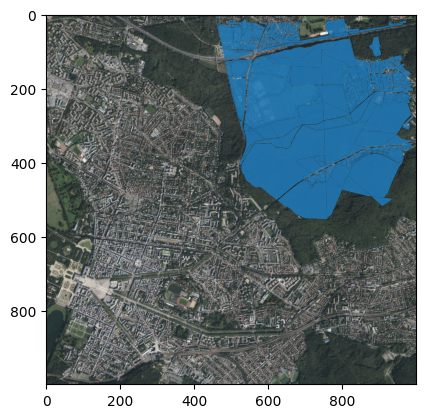

In [97]:
from shapely.geometry import Polygon, Point, MultiPolygon
import imageio, os.path, shapefile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

# Lecture du fichier contenant les parcelles
with open('workspace/Sample.shp', 'rb') as parcelleshp, open('workspace/Sample.dbf', 'rb') as parcelledbf, open('workspace/Sample.prj', 'rb') as parcelleprj:
    reader = shapefile.Reader(shp=parcelleshp, dbf=parcelledbf, prj=parcelleprj)

    # On fabrique un objet polygone avec les points de notre dalle
    poly = Polygon([ [635000, 6855000], [640000, 6855000], [640000, 6860000], [635000, 6860000] ])

    # On charge une petite version de l'image
    img = np.array(Image.open('workspace/Sample.png'), dtype = np.uint8)
    fig, ax = plt.subplots(1)
    ax.imshow(img, origin='upper')

    # On affiche les informations sur la dalle et l'image correspondante
    height, width = [ 1000, 1000 ]
    print("Image                                     : workspace/Sample.png")
    print("Dimensions de l'image                     : " + str(width) + "px x " + str(height) + "px")
    print("Système de coordonnées de référence (SCR) : EPSG:2154 - RGF93 v1 / Lambert-93")
    print("Coordonnées des bornes de l'image         : " + str(poly))
    origin = [ poly.boundary.bounds[0], poly.boundary.bounds[1] ]
    print("Origine relative (en mètre)               : " + str(origin))
    bounds = [ poly.boundary.bounds[2] - poly.boundary.bounds[0], poly.boundary.bounds[3] - poly.boundary.bounds[1] ]
    print("Dimensions de l'image (en mètre)          : " + str(bounds))

    # Le système de coordonnées Lambert 93 est assez simple : les coordonnées sont exprimées en mètres linéaires
    # à partir d'un origine en bas à gauche du cadre concerné.
    # Voir https://epsg.io/2154
    # Pour déterminer les coordonnées X,Y en pixel des parcelles, on applique pour le moment un produit en croix
    scale = [ width / (poly.boundary.bounds[2] - poly.boundary.bounds[0]), height / (poly.boundary.bounds[3] - poly.boundary.bounds[1]) ]
    print("Echelle (en px pour 1 mètre)              : " + str(scale))
    print("Nombre de parcelles (dans le shapefile)   : " + str(reader.numRecords))
    
    collection = []
    c = 0

    # On parcours les parcelles pour trouver celles incluses dans la dalle
    for n in range(0, reader.numRecords):
        
        inside = 0
        outside = 0
        parcel = reader.shape(n)
        for p in parcel.points:
            if (poly.contains(Point(p))):
                inside += 1
            else:
                outside += 1

        # On ignore les parcelles en dehors ou à cheval entre deux dalles
        if (inside == 0 or outside > 0):
            continue

        # Placement des points dans le référentiel local
        points = []
        for p in parcel.points:
            coord = [ p[0] - origin[0], p[1] - origin[1] ]
            x = ( int(coord[0] * scale[0]), height - int(coord[1] * scale[1]) )
            points.append(x)

        # Affichage d'un polygone
        c += 1
        collection.append(patches.Polygon(xy=points, closed=True, color='r'))
        
    print("Nombre de parcelles (dans les bornes)     : " + str(c))
    ax.add_collection(PatchCollection(collection, alpha=0.9))
    plt.show()


On constate cependant un problème : les coordonnées de la zone couverte ne sont pas les mêmes dans le fichier de maillage (mosaique) et dans un outil externe de contrôle comme QGis. Néanmoins, même si les points du polygone semblent donnés dans un ordre différent, cela n'a pas d'impacte sur les bornes de la zone couverte par l'imagerie (emprise).

In [15]:
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile

url = 's3://poc-automatic-land-parcel-recognition/dataset-reference-fr/092/'

with open(url + 'dalles.shp', 'rb', transport_params = {'client': session.client('s3')}) as dalleshp, open(url + 'dalles.dbf', 'rb', transport_params = {'client': session.client('s3')}) as dalledbf, open(url + 'dalles.prj', 'rb', transport_params = {'client': session.client('s3')}) as dalleprj:
    dallerdr = shapefile.Reader(shp=dalleshp, dbf=dalledbf, prj=dalleprj)
    for m in range(15, dallerdr.numRecords):
        if (dallerdr.record(m)[0] == './92-2021-0635-6860-LA93-0M20-E080.jp2'):
            poly = Polygon(dallerdr.shape(m).points)
            print(dallerdr.record(m))
            print("--- Coordinates")
            print("Computed : " + str(poly))
            print("Control  : POLYGON ((635000 6855000, 640000 6855000, 640000 6860000, 635000 6860000, 635000 6855000)) ❌")
            print("--- Emprise")
            print("Computed : " + str(poly.bounds))
            print("Control  : (635000.0, 6855000.0, 640000.0, 6860000.0) ✅")
            print("--- Origine (top/left)")
            print("Computed : (" + str(poly.boundary.bounds[0]) + ", " + str(poly.boundary.bounds[1]) + ")")
            print("Expected : (635000.0, 6855000.0) ✅")
            break
    


Record #17: ['./92-2021-0635-6860-LA93-0M20-E080.jp2']
--- Coordinates
Computed : POLYGON ((635000 6860000, 640000 6860000, 640000 6855000, 635000 6855000, 635000 6860000))
Control  : POLYGON ((635000 6855000, 640000 6855000, 640000 6860000, 635000 6860000, 635000 6855000)) ❌
--- Emprise
Computed : (635000.0, 6855000.0, 640000.0, 6860000.0)
Control  : (635000.0, 6855000.0, 640000.0, 6860000.0) ✅
--- Origine (top/left)
Computed : (635000.0, 6855000.0)
Expected : (635000.0, 6855000.0) ✅


## Itération des données

Dans cet exemple, on parcours un Shapefile spécial qui donne les bornes de la mosaique et les images correspondantes.

In [98]:
from shapely.geometry import Polygon, Point, MultiPolygon

url = 's3://poc-automatic-land-parcel-recognition/dataset-reference-fr/092/'
limit_dalles = 3

print("Système de coordonnées de référence (SCR) : EPSG:2154 - RGF93 v1 / Lambert-93")

# Lecture du fichier contenant les dalles
with open(url + 'dalles.shp', 'rb', transport_params = {'client': session.client('s3')}) as dalleshp, open(url + 'dalles.dbf', 'rb', transport_params = {'client': session.client('s3')}) as dalledbf, open(url + 'dalles.prj', 'rb', transport_params = {'client': session.client('s3')}) as dalleprj:
    dallerdr = shapefile.Reader(shp=dalleshp, dbf=dalledbf, prj=dalleprj)

    # On parcours les dalles
    for m in range(0, min(limit_dalles, dallerdr.numRecords)):

        # On fabrique un objet polygone avec les points de notre dalle
        poly = Polygon(dallerdr.shape(m).points)

        # On affiche les informations sur la dalle et l'image correspondante
        print("Dalle                                     : " + str(m))
        print(" - Image                                  : " + url + dallerdr.record(m)[0].replace('./', ''))
        print(" - Coordonnées des bornes de l'image      : " + str(poly))

Système de coordonnées de référence (SCR) : EPSG:2154 - RGF93 v1 / Lambert-93
Dalle                                     : 0
 - Image                                  : s3://poc-automatic-land-parcel-recognition/dataset-reference-fr/092/92-2021-0645-6855-LA93-0M20-E080.jp2
 - Coordonnées des bornes de l'image      : POLYGON ((645000 6855000, 650000 6855000, 650000 6850000, 645000 6850000, 645000 6855000))
Dalle                                     : 1
 - Image                                  : s3://poc-automatic-land-parcel-recognition/dataset-reference-fr/092/92-2021-0640-6870-LA93-0M20-E080.jp2
 - Coordonnées des bornes de l'image      : POLYGON ((640000 6870000, 645000 6870000, 645000 6865000, 640000 6865000, 640000 6870000))
Dalle                                     : 2
 - Image                                  : s3://poc-automatic-land-parcel-recognition/dataset-reference-fr/092/92-2021-0650-6860-LA93-0M20-E080.jp2
 - Coordonnées des bornes de l'image      : POLYGON ((650000 686000